In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Loading the dataset
test_data = pd.read_csv('TargetData.csv')


#Print the first 5 rows of the dataframe.
test_data.head()

X = test_data.drop(["ID","SB","COL","Margin","Block","ROW"],axis = 1)
y = test_data.SB

In [72]:
#importing train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=2, stratify=y)

from sklearn.tree import DecisionTreeClassifier

max_accuracy=0
best_depth=4
for DEPTH in range(10,16,1):
    dt = DecisionTreeClassifier(criterion='entropy',max_depth=DEPTH,random_state=0)
    dt.fit(X_train, y_train)
    print(DEPTH,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_depth=DEPTH
dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0)
dt.fit(X_train, y_train)        
print("selected depth: {:d}".format(best_depth))
print("Accuracy on training set: {:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dt.score(X_test, y_test)))

10 0.8448108632395732
11 0.8486905916585838
12 0.8516003879728419
13 0.8506304558680893
14 0.8516003879728419
15 0.8496605237633366
selected depth: 12
Accuracy on training set: 0.871
Accuracy on test set: 0.852


In [73]:
y_pred = dt.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[466  62]
 [ 91 412]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       528
           1       0.87      0.82      0.84       503

    accuracy                           0.85      1031
   macro avg       0.85      0.85      0.85      1031
weighted avg       0.85      0.85      0.85      1031



In [74]:
#DT visualizatin method 1

from sklearn.tree import export_graphviz

dotfile = open("dt2.dot", 'w')

export_graphviz(dt, out_file=dotfile,feature_names = X.columns,class_names=['0','1'])
dotfile.close()
# Copying the contents of the created file ('dt2.dot' ) to a graphviz rendering agent at http://webgraphviz.com/
# check out https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html

#DT visualizatin method 2
# need to install Graphviz first https://graphviz.gitlab.io/_pages/Download/Download_windows.html
from sklearn.tree import export_graphviz
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

export_graphviz(dt, out_file='tree.dot', feature_names=X.columns,class_names=['0','1'])
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=900'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

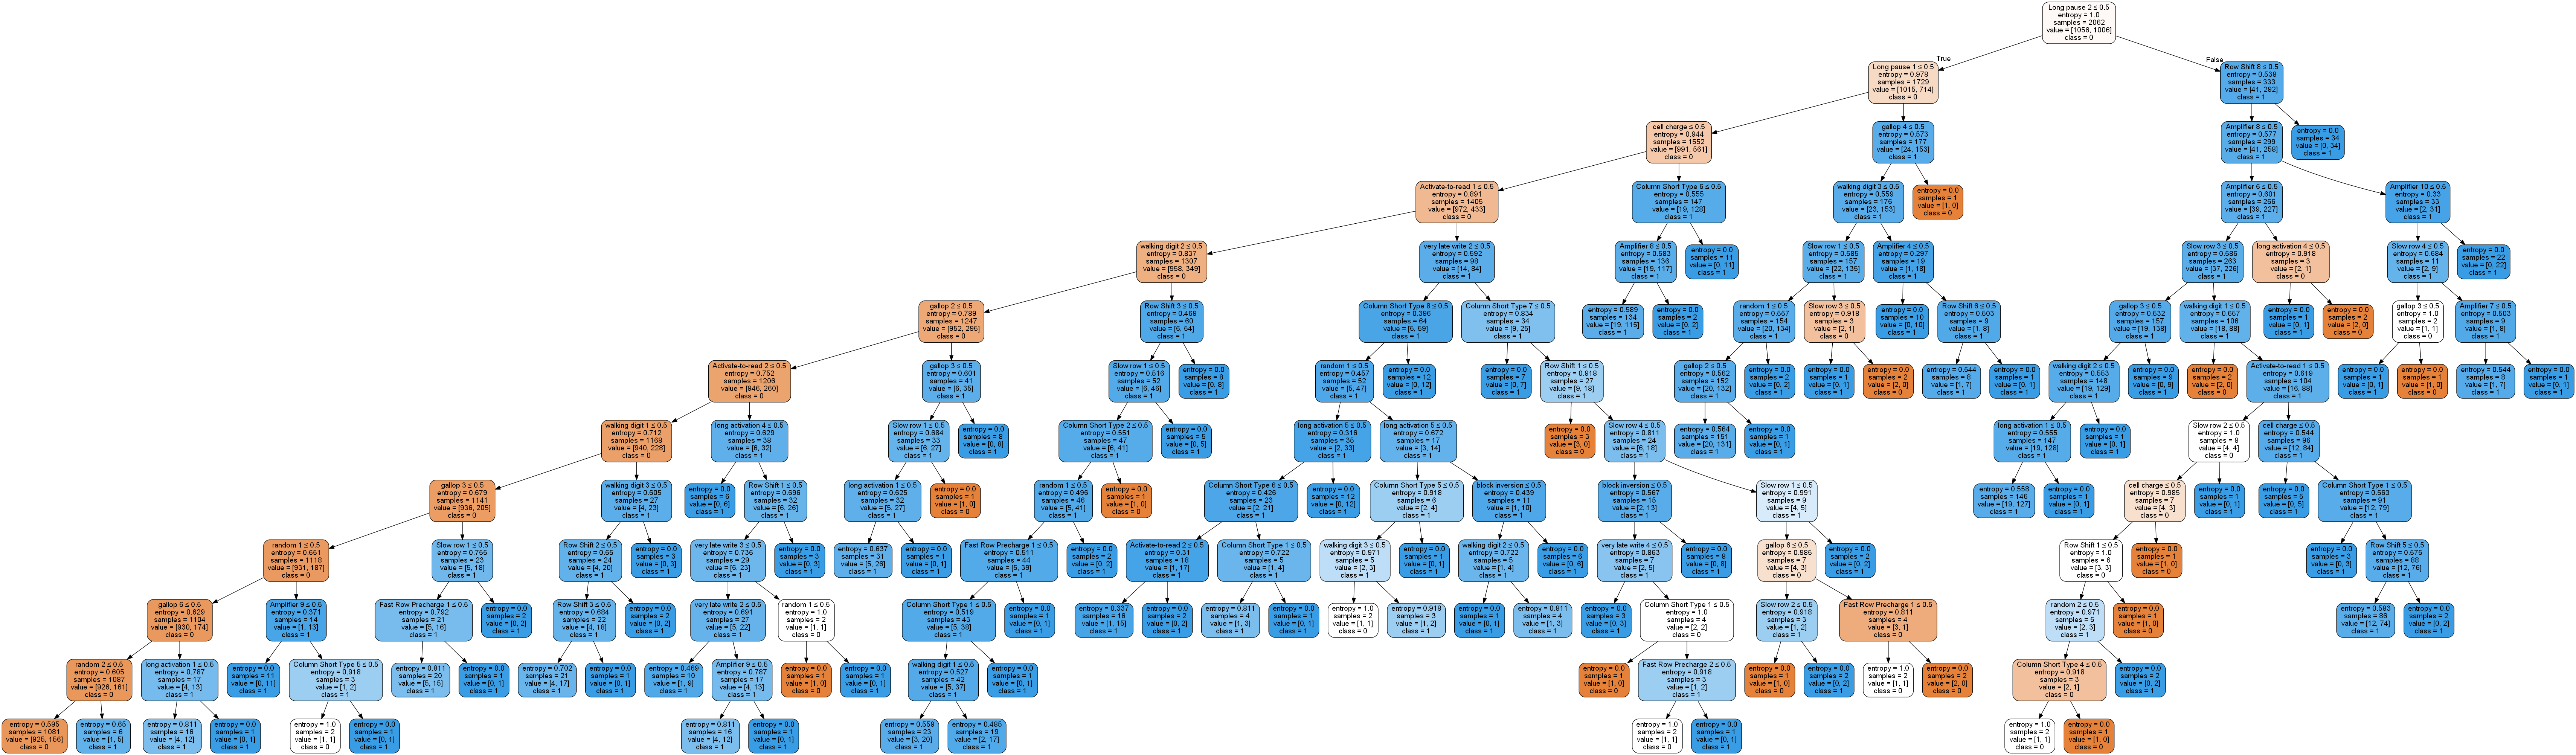

In [75]:
#DT visualizatin method 3
#!conda install -y pydotplus
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('testClassified.png')
Image(graph.create_png())

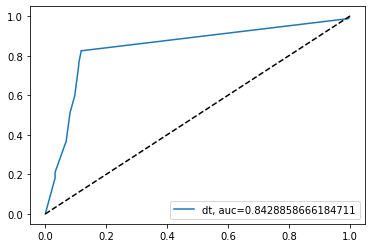

In [76]:
from sklearn import metrics

y_pred_proba = dt.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="dt, auc="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

In [77]:
print(dt.feature_importances_)
#print(sorted(dt.feature_importances_))

sorted_importance=sorted(dt.feature_importances_)
for i in range( len(dt.feature_importances_) ):
    if dt.feature_importances_[i]>0.5*sorted_importance[-1] or sorted_importance.index(dt.feature_importances_[i]) > len(dt.feature_importances_)-best_depth-1:
        #print(i)
        print(test_data.columns[i+1])
    

[1.35789292e-01 8.66871677e-04 0.00000000e+00 1.85988662e-03
 7.56046993e-03 2.45984657e-03 0.00000000e+00 9.68082904e-03
 3.14104651e-03 1.27136830e-01 1.06032932e-01 4.65955725e-02
 8.39403762e-02 0.00000000e+00 0.00000000e+00 3.93260324e-03
 1.94549544e-01 0.00000000e+00 5.38883459e-02 7.69427030e-04
 7.69427030e-04 3.71109306e-03 3.75151576e-03 1.88281451e-03
 3.59507298e-02 5.62318422e-04 1.63850539e-03 3.37869193e-02
 3.10716029e-03 2.96507214e-03 1.43706513e-03 5.00989421e-03
 0.00000000e+00 0.00000000e+00 2.41555755e-02 0.00000000e+00
 1.25339781e-02 5.23106448e-02 0.00000000e+00 2.96747242e-03
 1.14427050e-03 0.00000000e+00 0.00000000e+00 3.12665610e-03
 4.36520305e-04 3.62247160e-03 1.84291952e-04 6.77729144e-04
 4.47207249e-03 2.08117096e-03 2.06406376e-03 2.38650737e-03
 1.59704952e-03 1.84291952e-04 2.89782600e-03 3.42522246e-03
 0.00000000e+00 6.95579703e-03]
cell charge
Long pause 1
Activate-to-read 1
walking digit 1
walking digit 2
Long pause 2
gallop 2
gallop 3
random 

In [78]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000,verbose=2)  
mlp.fit(X_train, y_train)  

predictions = mlp.predict(X_test)  


print("Accuracy", metrics.accuracy_score(y_test, predictions))
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  
print(mlp.coefs_[0][1])

Iteration 1, loss = 0.75683359
Iteration 2, loss = 0.66772337
Iteration 3, loss = 0.63780250
Iteration 4, loss = 0.62155994
Iteration 5, loss = 0.60713206
Iteration 6, loss = 0.59240275
Iteration 7, loss = 0.57893664
Iteration 8, loss = 0.56559367
Iteration 9, loss = 0.55334184
Iteration 10, loss = 0.54071254
Iteration 11, loss = 0.52966333
Iteration 12, loss = 0.51933211
Iteration 13, loss = 0.50986463
Iteration 14, loss = 0.50162562
Iteration 15, loss = 0.49375523
Iteration 16, loss = 0.48625494
Iteration 17, loss = 0.48027753
Iteration 18, loss = 0.47379594
Iteration 19, loss = 0.46813073
Iteration 20, loss = 0.46308168
Iteration 21, loss = 0.45820849
Iteration 22, loss = 0.45391440
Iteration 23, loss = 0.44992759
Iteration 24, loss = 0.44604986
Iteration 25, loss = 0.44283009
Iteration 26, loss = 0.44024928
Iteration 27, loss = 0.43686143
Iteration 28, loss = 0.43417385
Iteration 29, loss = 0.43173916
Iteration 30, loss = 0.42895149
Iteration 31, loss = 0.42704349
Iteration 32, los

Iteration 266, loss = 0.37070686
Iteration 267, loss = 0.37074679
Iteration 268, loss = 0.37016252
Iteration 269, loss = 0.37026232
Iteration 270, loss = 0.37033676
Iteration 271, loss = 0.37016809
Iteration 272, loss = 0.37028896
Iteration 273, loss = 0.37018464
Iteration 274, loss = 0.37063992
Iteration 275, loss = 0.36983693
Iteration 276, loss = 0.37113869
Iteration 277, loss = 0.36972059
Iteration 278, loss = 0.37059950
Iteration 279, loss = 0.37014105
Iteration 280, loss = 0.37033785
Iteration 281, loss = 0.36998507
Iteration 282, loss = 0.36939960
Iteration 283, loss = 0.36920882
Iteration 284, loss = 0.36925765
Iteration 285, loss = 0.36976804
Iteration 286, loss = 0.36941170
Iteration 287, loss = 0.36934671
Iteration 288, loss = 0.36924809
Iteration 289, loss = 0.36955386
Iteration 290, loss = 0.36915839
Iteration 291, loss = 0.36964465
Iteration 292, loss = 0.36887053
Iteration 293, loss = 0.36929429
Iteration 294, loss = 0.36890346
Iteration 295, loss = 0.36895065
Iteration 

In [79]:


feature={}
node_feature=[]

for l in range(10):
    min_weight=mlp.coefs_[0][0:][l].min()
    max_weight=mlp.coefs_[0][0:][l].max()
    if abs(min_weight)>abs(max_weight): max_weight=abs(min_weight)
    max_weight=abs(max_weight)
    for i in range(58):
        weight = mlp.coefs_[0][i][l]
        if weight>0 and weight/max_weight>0.33: 
            if test_data.columns[i+1] not in feature: 
                feature[ test_data.columns[i+1] ]=0
            feature[ test_data.columns[i+1] ]+=1
            node_feature.append(test_data.columns[i+1])
        elif weight<0 and weight/max_weight>0.33: 
            if test_data.columns[i+1] not in feature: 
                feature[ test_data.columns[i+1] ]=0
            feature[ test_data.columns[i+1] ]+=1
            node_feature.append(test_data.columns[i+1])
    print(node_feature)
    node_feature=[]
        
for f in feature: 
    if feature[f]>5: print(f)
        
    
    

['Long pause 1', 'walking digit 1', 'gallop 3', 'Row Shift 2', 'random 1', 'random 2', 'Activate-to-read 2', 'Column Short Type 7']
['cell charge', 'Row Shift 1', 'Slow row 1', 'Column Short Type 2', 'Long pause 1', 'Activate-to-read 1', 'walking digit 1', 'Slow row 2', 'Long pause 2', 'long activation 2', 'Column Short Type 4', 'walking digit 3', 'Column Short Type 5', 'very late write 2', 'Amplifier 2', 'Row Shift 4', 'Column Short Type 6', 'Amplifier 5', 'long activation 3', 'Row Shift 5', 'Column Short Type 7', 'Amplifier 8', 'Column Short Type 8', 'Amplifier 10', 'Row Shift 8']
['cell charge', 'gallop 1', 'Row Shift 1', 'Column Short Type 1', 'very late write 1', 'Slow row 1', 'walking digit 1', 'walking digit 2', 'Slow row 2', 'long activation 2', 'gallop 2', 'block inversion', 'walking digit 3', 'gallop 3', 'Row Shift 2', 'Row Shift 3', 'Column Short Type 5', 'very late write 2', 'Row Shift 4', 'random 2', 'Amplifier 3', 'Column Short Type 6', 'long activation 3', 'Column Short 

In [80]:
featurelist={}
for testnum in range(58):
    featurelist[test_data.columns[testnum+1]]=0

for i in range(len(X_test)):
    if predictions[i]==1:
        for testnum in range(58):
            featurelist[test_data.columns[testnum+1]]+=1
            
for f in featurelist:
    if featurelist[f]>len(X_test)*0.1:
        print(f)
        
    

    

cell charge
long activation 1
gallop 1
Fast Row Precharge 1
Row Shift 1
Column Short Type 1
very late write 1
Slow row 1
Column Short Type 2
Long pause 1
Activate-to-read 1
walking digit 1
walking digit 2
Column Short Type 3
Amplifier 1
Slow row 2
Long pause 2
long activation 2
gallop 2
Column Short Type 4
Fast Row Precharge 2
Slow row 3
block inversion
walking digit 3
gallop 3
Row Shift 2
Row Shift 3
random 1
Slow row 4
gallop 4
Column Short Type 5
very late write 2
gallop 5
Amplifier 2
gallop 6
Row Shift 4
random 2
Activate-to-read 2
Amplifier 3
Column Short Type 6
Amplifier 4
Amplifier 5
long activation 3
Amplifier 6
Row Shift 5
Column Short Type 7
Amplifier 7
very late write 3
long activation 4
very late write 4
Amplifier 8
long activation 5
Column Short Type 8
Row Shift 6
Amplifier 9
Amplifier 10
Row Shift 7
Row Shift 8
